In [1]:
# Import Python modules
import os, sys
from pathlib import Path
import numpy as np
import numpy.ma as ma
import pandas as  pd
import xarray as xr
from sklearn.cluster import KMeans
from scipy import stats
# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.colors import ListedColormap
from matplotlib import rcParams
import matplotlib.ticker as mticker
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

from IPython.display import Image, display

# Path to modules
sys.path.append('../modules')

# Import my modules
from plotter import draw_basemap
from timeseries import persistence
from eofs import *
from ar_funcs import preprocess_ar_area_subregions
from kmeans import *

In [2]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                            # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/AR_types/out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/AR_types/figs/'      # figures

# Set a default font for all matplotlib text (can only set this ONCE; must restart kernel to change it)

rcParams['font.family'] = 'sans-serif'   # set the default font family to 'sans-serif'
rcParams['font.sans-serif'] = 'Arial'    # set the default sans-serif font to 'Arial'

In [3]:
## Select MERRA2 or ERA5
reanalysis = 'era5'

if reanalysis == 'era5':
    start_date = '1979-01-01'
    end_date = '2018-12-31'
    filename = 'ar_catalog_ERAI_fraction_HASIAsubregions.nc'
## if MERRA2
else:
    start_date = '1980-01-01'
    end_date = '2017-12-31'
    filename = 'ar_catalog_fraction_HASIAsubregions.nc'
    
f1 = path_to_data + 'CH1_generated_data/' + filename
ds = xr.open_dataset(f1)
# Set dates
ds = ds.sel(time=slice(start_date, end_date))
## Preprocess AR subregions - get dataframe of AR days based on area threshold
df = preprocess_ar_area_subregions(df=ds.to_dataframe(), thres=0.3)
# Show table
df.head()

,R01,R02,R03,ar,location
time,,,,,
1979-01-01,0.000000,0.0,0.0,0,NaN
1979-01-02,0.000000,0.0,0.0,0,NaN
1979-01-03,0.005102,0.0,0.0,0,NaN
1979-01-04,0.000000,0.0,0.0,0,NaN
1979-01-05,0.000000,0.0,0.0,0,NaN


In [18]:
len(df)

14610

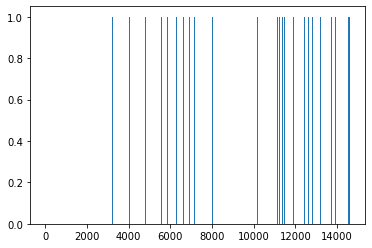

In [22]:
## time series of AR Days
fig, ax = plt.subplots(figsize=(6,4))
x=np.arange(len(df))
## Use the following syntax to access data via variable/column names
y=df.ar
## Use matplotlib's plot_date function when your x-axis is a datetime series
ax.bar(x, y)

plt.show()

In [28]:
## import HMA loadings t-mode correlation matrix
filename = path_to_out + 'loadings_HUV250QUV850t0120-1565cor.txt'
col_names = ['PC1', 'PC2', 'PC3', 'PC4']
df1 = pd.read_csv(filename, header=None, names=col_names)
df1



xx = df1.PC1.values
yy = df1.PC2.values

print(np.isnan(xx).any())
print(np.isnan(yy).any())

print(np.isinf(xx).any())
print(np.isinf(yy).any())

r, pval = stats.pearsonr(xx, yy)
print(r, pval)

False
False
False
False
-4.5173129602654044e-05 0.9993081066878995


In [29]:
df1

,PC1,PC2,PC3,PC4
0,-0.2770,0.1899,-0.0082,0.2884
1,-0.2056,-0.1514,-0.2012,0.1681
2,-0.2794,0.1637,0.0956,-0.2440
3,-0.1528,0.0225,0.2748,-0.2840
4,-0.2039,-0.1559,0.1917,0.3107
...,...,...,...,...
366,0.0952,0.3809,0.0062,0.0246
367,0.0064,0.5163,0.1302,0.1752
368,0.4073,-0.1279,0.2194,0.2621
369,0.2749,-0.0061,0.0545,0.0686


In [31]:
np.std(yy)

0.26164609373385356

In [32]:
np.mean(yy)

-0.0002560646900269535

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fba48406310>,
      dtype=object)

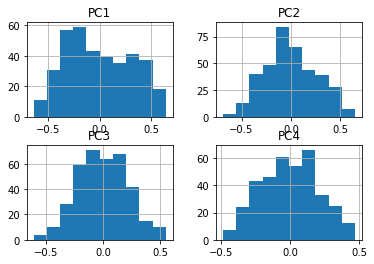

In [33]:
df1.hist()

In [42]:
df1.PC1 
std_PC = np.std(df1)
mean_PC = np.mean(df1)
std_PC
idx = (df1['PC1']-mean_PC.PC1 >= std_PC.PC1) | (df1['PC1']-mean_PC.PC1 <= std_PC.PC1*-1)
PC1_sel = df1.PC1.loc[idx]

idx = (df1['PC2']-mean_PC.PC2 >= std_PC.PC2) | (df1['PC2']-mean_PC.PC2 <= std_PC.PC2*-1)
PC2_sel = df1.PC2.loc[idx]

(-1.0, 1.0)

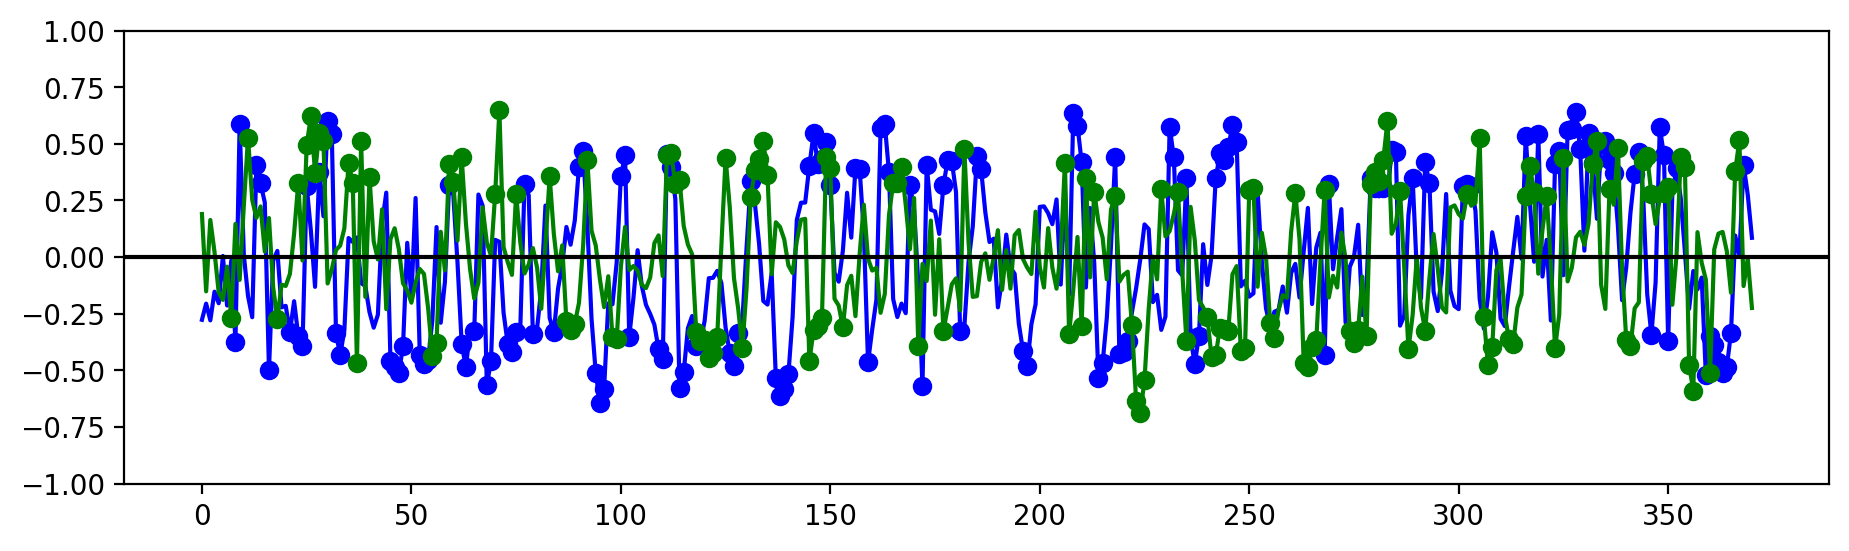

In [43]:
fig = plt.figure(figsize=(11, 3))
fig.dpi = 200
fmt = 'png'

x = np.arange(len(xx))


ax = plt.subplot(111)
ax.plot(x, xx, 'b-')
ax.plot(PC1_sel.index, PC1_sel.values, 'bo')
ax.plot(x, yy, 'g-')
ax.plot(PC2_sel.index, PC2_sel.values, 'go')
ax.axhline(0, color='k')
ax.set_ylim(-1, 1)

In [53]:
filename = path_to_out + 'HUV250QUV850t0120-1565corhma_AR-types-djf.csv'
df = pd.read_csv(filename)
df

,Unnamed: 0,AR_CAT,EOF_CAT,EOF_CAT1,EOF_CAT2
0,1979-12-01 09:00:00,1,0,0,0
1,1979-12-02 09:00:00,1,0,0,0
2,1979-12-03 09:00:00,0,0,0,0
3,1979-12-04 09:00:00,0,0,0,0
4,1979-12-05 09:00:00,0,0,0,0
...,...,...,...,...,...
3515,2018-02-24 09:00:00,0,0,0,0
3516,2018-02-25 09:00:00,0,0,0,0
3517,2018-02-26 09:00:00,2,0,0,0
3518,2018-02-27 09:00:00,0,0,0,0


In [52]:
df.EOF_CAT2.sum()

133

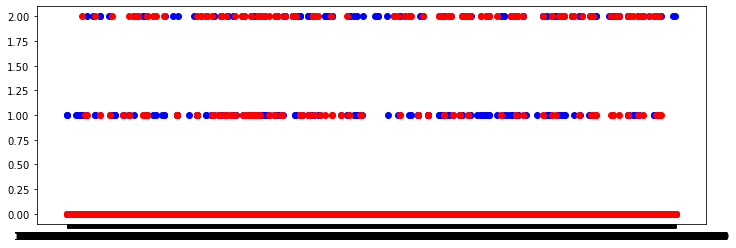

In [54]:
## time series of AR Days
fig, ax = plt.subplots(figsize=(12,4))
x=df.iloc[:, 0].values
ax.plot_date(x, df.AR_CAT, 'bo')
ax.plot_date(x, df.EOF_CAT, 'ro')

plt.show()

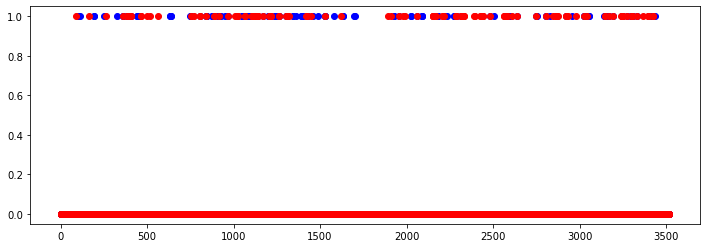

In [55]:
## time series of AR Days
fig, ax = plt.subplots(figsize=(12,4))
x=np.arange(len(df))
ax.plot(x, df.EOF_CAT1, 'bo')
ax.plot(x, df.EOF_CAT2, 'ro')

plt.show()